In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
import time

import py_analyze_tools.tools as pat

# Cross validate with two realisations
Two realisations with __different initial conditions__, but with the same generating reactions. Train with one, test with the other.

## Show estimation of individual trajs with some hyperparameter $\alpha$

In [2]:
def register_reactions_to_traj(traj):
    traj.add_fusion(0, 1, 2) # A + B -> C, true
    traj.add_fusion(2, 3, 1) # C + D -> B, true
    traj.add_fission(2, 0, 1) # C -> A + B, nope
    traj.add_conversion(0, 1) # A -> B, nope
    traj.add_conversion(0, 3) # A -> D, true
    traj.add_conversion(3, 0) # D -> A, true

def expected_propensities():
    xi = [
        1.981e-06,
        1.981e-06,
        0.0,
        0.0,
        0.02,
        0.02
    ]
    return xi
    
def show_lasso_estimate(traj, alpha):
    xi = traj.estimate(alpha)

    def fun(data, _):
        theta = np.array([f(data) for f in traj.thetas])
        return np.matmul(xi, theta)

    num_solution = odeint(fun, traj.counts[0], np.arange(0, traj.n_time_steps*.01, .01))
    for i in range(traj.n_species):
        plt.plot(np.arange(0, traj.n_time_steps*.01, .01), traj.counts[:,i], "--")
        plt.plot(np.arange(0, traj.n_time_steps*.01, .01), num_solution[:, i])
    plt.ylabel("Number of particles")
    plt.xlabel("Time")
    return xi

max counts = 6000.0, min nonzero counts = 1.0


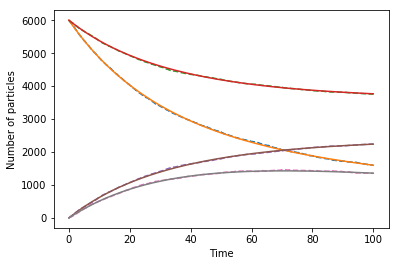

est. prop.: 2.04953223059e-06 	exp. prop.: 1.981e-06
est. prop.: 1.92636356699e-06 	exp. prop.: 1.981e-06
est. prop.: 0.00103487138457 	exp. prop.: 0.0
est. prop.: 2.41550223102e-05 	exp. prop.: 0.0
est. prop.: 0.0100541489029 	exp. prop.: 0.02
est. prop.: 0.0104862402875 	exp. prop.: 0.02


In [3]:
traj_1 = pat.Trajectory("../generate/two_realisations_1.h5")
traj_1.counts = traj_1.counts[:10000]
register_reactions_to_traj(traj_1)
xi_1 = show_lasso_estimate(traj_1, 0.003)
plt.show()
for i in range(len(xi_1)):
    print("est. prop.:", xi_1[i], "\texp. prop.:", expected_propensities()[i])

max counts = 8000.0, min nonzero counts = 2.0


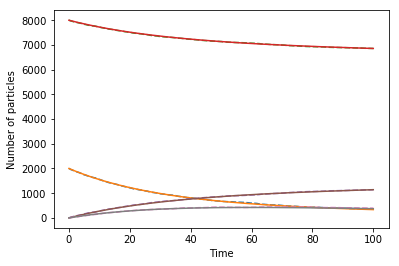

est. prop.: 1.99442031194e-06 	exp. prop.: 1.981e-06
est. prop.: 2.4766112285e-06 	exp. prop.: 1.981e-06
est. prop.: 5.801027429e-09 	exp. prop.: 0.0
est. prop.: 0.0 	exp. prop.: 0.0
est. prop.: 0.0103216310932 	exp. prop.: 0.02
est. prop.: 0.0115699841692 	exp. prop.: 0.02


In [4]:
traj_2 = pat.Trajectory("../generate/two_realisations_2.h5")
traj_2.counts = traj_2.counts[:10000]
register_reactions_to_traj(traj_2)
xi_2 = show_lasso_estimate(traj_2, 0.003)
plt.show()
for i in range(len(xi_2)):
    print("est. prop.:", xi_2[i], "\texp. prop.:", expected_propensities()[i])

## Cross validate traj_1 and traj_2 to find optimal hyperparameter $\hat{\alpha}$

In [5]:
cv = pat.CV(traj_1, traj_2)

In [6]:
t1 = time.time()
very_coarse_result = cv.calculate_cost(
    np.linspace(0., 40000., 40), range(0, 5000), range(5000, 10000)
)
alphas_very_coarse = very_coarse_result.alphas
costs_train_very_coarse = very_coarse_result.costs_train
costs_test_very_coarse = very_coarse_result.costs_test
print("Duration: ", time.time() - t1)

Duration:  309.52407002449036


In [7]:
t1 = time.time()
coarse_result = cv.calculate_cost(
    np.linspace(0., 4000., 40), range(0, 5000), range(5000, 10000)
)
alphas_coarse = coarse_result.alphas
costs_train_coarse = coarse_result.costs_train
costs_test_coarse = coarse_result.costs_test
print("Duration: ", time.time() - t1)

Duration:  359.6876816749573


In [8]:
t1 = time.time()
fine_result = cv.calculate_cost(
    np.linspace(0., 400., 40), range(0, 5000), range(5000, 10000)
)
alphas_fine = fine_result.alphas
costs_train_fine = fine_result.costs_train
costs_test_fine = fine_result.costs_test
print("Duration: ", time.time() - t1)

Duration:  400.7531774044037


In [9]:
current_scale = 1. / (2.*traj_1.n_species * traj_2.n_time_steps)
norm_of_coeff = np.linalg.norm(fine_result.coefficients[0], ord=1)
print("norm of coefficients for alpha=0: {}".format(norm_of_coeff))
quotient = current_scale * (fine_result.costs_test[0]*fine_result.costs_test[0]) / norm_of_coeff
print("quotient = {}, order of magnitude = {}".format(quotient, pat.magnitude(quotient)))

norm of coefficients for alpha=0: 0.022182864573901007
quotient = 5887.847872003613, order of magnitude = 3


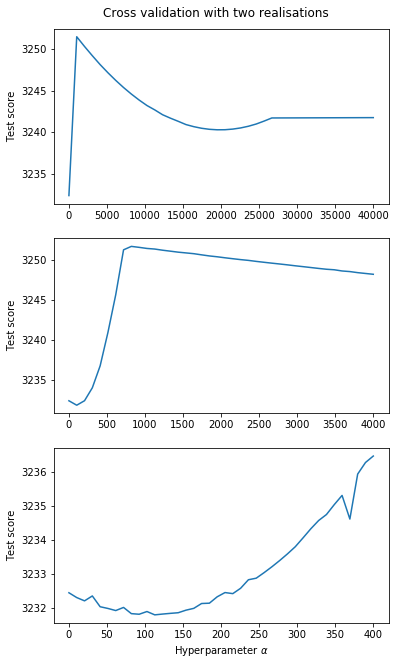

In [10]:
fig, axarr = plt.subplots(3, figsize=(6,10))
axarr[0].plot(alphas_very_coarse, costs_test_very_coarse)
axarr[1].plot(alphas_coarse, costs_test_coarse)
axarr[2].plot(alphas_fine, costs_test_fine)
axarr[2].set_xlabel(r"Hyperparameter $\alpha$")
for i in range(3): axarr[i].set_ylabel(r"Test score")
fig.suptitle("Cross validation with two realisations")
plt.subplots_adjust(top=0.95)
plt.show()

In [11]:
optimal_alpha = alphas_fine[np.argmin(costs_test_fine)]
print("Optimal alpha: ", optimal_alpha)

Optimal alpha:  112.820512821


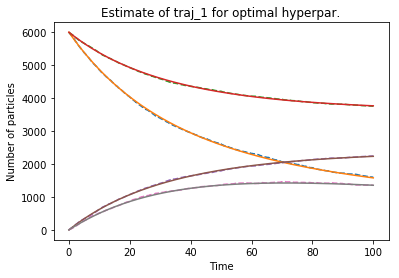

propensities for optimal alpha compared with expected values, traj_1
est. prop.: 2.04927684956e-06 	exp. prop.: 1.981e-06
est. prop.: 2.0208395103e-06 	exp. prop.: 1.981e-06
est. prop.: 0.000936604781641 	exp. prop.: 0.0
est. prop.: 0.0 	exp. prop.: 0.0
est. prop.: 0.00989087301725 	exp. prop.: 0.02
est. prop.: 0.00996487621911 	exp. prop.: 0.02


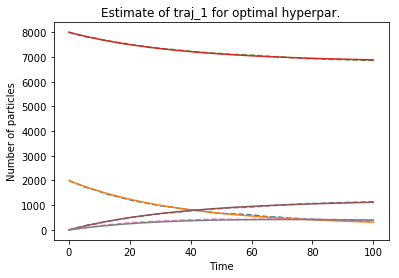

propensities for optimal alpha compared with expected values, traj_2
est. prop.: 2.06239181119e-06 	exp. prop.: 1.981e-06
est. prop.: 2.87894097723e-06 	exp. prop.: 1.981e-06
est. prop.: 0.000600733370062 	exp. prop.: 0.0
est. prop.: 0.0 	exp. prop.: 0.0
est. prop.: 0.00861947229253 	exp. prop.: 0.02
est. prop.: 0.00660283328016 	exp. prop.: 0.02


In [12]:
xi_1 = show_lasso_estimate(traj_1, optimal_alpha)
plt.title("Estimate of traj_1 for optimal hyperpar.")
plt.show()
print("propensities for optimal alpha compared with expected values, traj_1")
for i in range(len(xi_1)):
    print("est. prop.:", xi_1[i], "\texp. prop.:", expected_propensities()[i])

xi_2 = show_lasso_estimate(traj_2, optimal_alpha)
plt.title("Estimate of traj_1 for optimal hyperpar.")
plt.show()
print("propensities for optimal alpha compared with expected values, traj_2")
for i in range(len(xi_2)):
    print("est. prop.:", xi_2[i], "\texp. prop.:", expected_propensities()[i])